In [1]:
from __future__ import print_function
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob

C:\Users\r09922110\anaconda3\envs\ML\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\r09922110\anaconda3\envs\ML\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\r09922110\anaconda3\envs\ML\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\r09922110\anaconda3\envs\ML\lib\site-packages\tensorflow\pyth

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import skimage.transform as trans

In [3]:
from cv2 import cv2

In [4]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras

In [5]:
import os
import numpy as np 
import skimage.io as io
from PIL import Image

In [6]:
import copy

# Model structure

In [7]:
def unet_2(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

# Dice score function and Dice loss

In [8]:
# metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    # 2*(TP+1)/(TP+FN+TP+FP+1)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# auxiliary function

In [9]:
def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)

def geneTrainNpy(image_path,mask_path,image_prefix,flag_multi_class = False,num_class = 2):
    image_name_arr = glob.glob(os.path.join(image_path,"%s*.png"%image_prefix))
    image_arr = []
    mask_arr = []
    for index,item in enumerate(image_name_arr):
        try:
            img = cv2.imread(item,cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img,(256,256))
            img = np.reshape(img,img.shape + (1,))
            mask = cv2.imread(item.replace(image_path,mask_path).replace('.png','_mask.png'),cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask,(256,256))
            mask = np.reshape(mask,mask.shape + (1,))
            img,mask = adjustData(img,mask,flag_multi_class,num_class)
            image_arr.append(img)
            mask_arr.append(mask)
        except:
            print(item,'no mask')
    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr,mask_arr


def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255



def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

In [10]:
#data load in
train_image_arr,train_mask_arr = geneTrainNpy(r"C:\Users\r09922110\mip\lung_dataset\Lung Segmentation\CXR_png",r"C:\Users\r09922110\mip\lung_dataset\Lung Segmentation\masks",image_prefix='CHNCXR')

C:\Users\r09922110\mip\lung_dataset\Lung Segmentation\CXR_png\CHNCXR_0025_0.png no mask
C:\Users\r09922110\mip\lung_dataset\Lung Segmentation\CXR_png\CHNCXR_0036_0.png no mask
C:\Users\r09922110\mip\lung_dataset\Lung Segmentation\CXR_png\CHNCXR_0037_0.png no mask
C:\Users\r09922110\mip\lung_dataset\Lung Segmentation\CXR_png\CHNCXR_0038_0.png no mask
C:\Users\r09922110\mip\lung_dataset\Lung Segmentation\CXR_png\CHNCXR_0039_0.png no mask
C:\Users\r09922110\mip\lung_dataset\Lung Segmentation\CXR_png\CHNCXR_0040_0.png no mask
C:\Users\r09922110\mip\lung_dataset\Lung Segmentation\CXR_png\CHNCXR_0065_0.png no mask
C:\Users\r09922110\mip\lung_dataset\Lung Segmentation\CXR_png\CHNCXR_0181_0.png no mask
C:\Users\r09922110\mip\lung_dataset\Lung Segmentation\CXR_png\CHNCXR_0182_0.png no mask
C:\Users\r09922110\mip\lung_dataset\Lung Segmentation\CXR_png\CHNCXR_0183_0.png no mask
C:\Users\r09922110\mip\lung_dataset\Lung Segmentation\CXR_png\CHNCXR_0184_0.png no mask
C:\Users\r09922110\mip\lung_data

C:\Users\r09922110\mip\lung_dataset\Lung Segmentation\CXR_png\CHNCXR_0564_1.png no mask
C:\Users\r09922110\mip\lung_dataset\Lung Segmentation\CXR_png\CHNCXR_0565_1.png no mask


In [11]:
test_image_arr,test_mask_arr = geneTrainNpy(r"C:\Users\r09922110\mip\lung_dataset\Lung Segmentation\CXR_png",r"C:\Users\r09922110\mip\lung_dataset\Lung Segmentation\masks",image_prefix='MCUCXR')

In [12]:
train_image_arr.shape

(566, 256, 256, 1)

In [13]:
test_image_arr.shape

(138, 256, 256, 1)

# training

In [286]:
model_unet = unet_2()
model_unet.compile(optimizer = Adam(lr = 1e-5), loss = dice_coef_loss, metrics = [dice_coef,'binary_accuracy'])

In [287]:
from tensorflow.keras.utils import plot_model
plot_model(model_unet,to_file='./unet_2.jpg',show_shapes=True)

In [288]:
model_unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 256, 256, 32) 320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_54[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_55[0][0]                  
__________________________________________________________________________________________________
conv2d_56 

In [289]:
model_checkpoint = ModelCheckpoint('unet_lung_seg_2_epoch_100.hdf5', 
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_best_only=True)
train_history = model_unet.fit(train_image_arr,train_mask_arr,validation_split=0.2,epochs=100,batch_size=2,callbacks=[model_checkpoint])

Train on 452 samples, validate on 114 samples
Epoch 1/100
450/452 [============================>.] - ETA: 0s - loss: -0.3508 - dice_coef: 0.3508 - binary_accuracy: 0.2488
Epoch 00001: val_loss improved from inf to -0.44189, saving model to unet_lung_seg_2_epoch_100.hdf5
452/452 [==============================] - 9s 20ms/sample - loss: -0.3509 - dice_coef: 0.3509 - binary_accuracy: 0.2487 - val_loss: -0.4419 - val_dice_coef: 0.4419 - val_binary_accuracy: 0.2710
Epoch 2/100
450/452 [============================>.] - ETA: 0s - loss: -0.6407 - dice_coef: 0.6407 - binary_accuracy: 0.7186
Epoch 00002: val_loss improved from -0.44189 to -0.78345, saving model to unet_lung_seg_2_epoch_100.hdf5
452/452 [==============================] - 6s 13ms/sample - loss: -0.6416 - dice_coef: 0.6416 - binary_accuracy: 0.7195 - val_loss: -0.7835 - val_dice_coef: 0.7835 - val_binary_accuracy: 0.8769
Epoch 3/100
450/452 [============================>.] - ETA: 0s - loss: -0.8078 - dice_coef: 0.8078 - binary_acc

Epoch 21/100
450/452 [============================>.] - ETA: 0s - loss: -0.9267 - dice_coef: 0.9267 - binary_accuracy: 0.9645
Epoch 00021: val_loss improved from -0.93539 to -0.93749, saving model to unet_lung_seg_2_epoch_100.hdf5
452/452 [==============================] - 7s 15ms/sample - loss: -0.9268 - dice_coef: 0.9268 - binary_accuracy: 0.9645 - val_loss: -0.9375 - val_dice_coef: 0.9375 - val_binary_accuracy: 0.9670
Epoch 22/100
450/452 [============================>.] - ETA: 0s - loss: -0.9277 - dice_coef: 0.9277 - binary_accuracy: 0.9652
Epoch 00022: val_loss did not improve from -0.93749
452/452 [==============================] - 7s 15ms/sample - loss: -0.9278 - dice_coef: 0.9278 - binary_accuracy: 0.9653 - val_loss: -0.9352 - val_dice_coef: 0.9352 - val_binary_accuracy: 0.9650
Epoch 23/100
450/452 [============================>.] - ETA: 0s - loss: -0.9299 - dice_coef: 0.9299 - binary_accuracy: 0.9659
Epoch 00023: val_loss improved from -0.93749 to -0.93974, saving model to une

Epoch 62/100
450/452 [============================>.] - ETA: 0s - loss: -0.9548 - dice_coef: 0.9548 - binary_accuracy: 0.9779
Epoch 00062: val_loss did not improve from -0.96088
452/452 [==============================] - 7s 15ms/sample - loss: -0.9547 - dice_coef: 0.9547 - binary_accuracy: 0.9779 - val_loss: -0.9606 - val_dice_coef: 0.9606 - val_binary_accuracy: 0.9789
Epoch 63/100
450/452 [============================>.] - ETA: 0s - loss: -0.9547 - dice_coef: 0.9547 - binary_accuracy: 0.9779
Epoch 00063: val_loss did not improve from -0.96088
452/452 [==============================] - 7s 15ms/sample - loss: -0.9546 - dice_coef: 0.9546 - binary_accuracy: 0.9779 - val_loss: -0.9603 - val_dice_coef: 0.9603 - val_binary_accuracy: 0.9785
Epoch 64/100
450/452 [============================>.] - ETA: 0s - loss: -0.9548 - dice_coef: 0.9548 - binary_accuracy: 0.9780
Epoch 00064: val_loss did not improve from -0.96088
452/452 [==============================] - 7s 15ms/sample - loss: -0.9547 - di

Epoch 84/100
450/452 [============================>.] - ETA: 0s - loss: -0.9578 - dice_coef: 0.9578 - binary_accuracy: 0.9794
Epoch 00084: val_loss did not improve from -0.96299
452/452 [==============================] - 7s 15ms/sample - loss: -0.9579 - dice_coef: 0.9579 - binary_accuracy: 0.9794 - val_loss: -0.9617 - val_dice_coef: 0.9617 - val_binary_accuracy: 0.9795
Epoch 85/100
450/452 [============================>.] - ETA: 0s - loss: -0.9590 - dice_coef: 0.9590 - binary_accuracy: 0.9799
Epoch 00085: val_loss did not improve from -0.96299
452/452 [==============================] - 7s 15ms/sample - loss: -0.9591 - dice_coef: 0.9591 - binary_accuracy: 0.9799 - val_loss: -0.9625 - val_dice_coef: 0.9625 - val_binary_accuracy: 0.9800
Epoch 86/100
450/452 [============================>.] - ETA: 0s - loss: -0.9588 - dice_coef: 0.9588 - binary_accuracy: 0.9798
Epoch 00086: val_loss did not improve from -0.96299
452/452 [==============================] - 7s 15ms/sample - loss: -0.9588 - di

In [14]:
model_unet = unet_2()

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
model_unet.load_weights('./unet_lung_seg_2_epoch_100.hdf5')

# Performance

In [21]:
def plot_error(train_history):
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right') 
    plt.show()

In [22]:
def plot_acc(train_history):
    plt.plot(train_history.history['binary_accuracy'])
    plt.plot(train_history.history['val_binary_accuracy'])
    plt.title('model acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right') 
    plt.show()

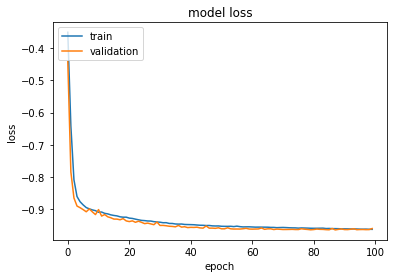

In [290]:
plot_error(train_history)

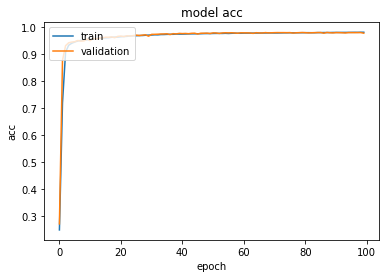

In [291]:
plot_acc(train_history)

# Prediction

In [16]:
test_predit_arr = model_unet.predict(test_image_arr)

# Visualization

In [176]:
def show_predict(test_predict,t):
    test = copy.deepcopy(test_predict)
    test[test>t] = 255
    test[test<=t] = 0
    return test

In [177]:
def show_image(test_image):
    test = copy.deepcopy(test_image)
    test = test*255
    test = np.reshape(test,(256,256))
    test = cv2.cvtColor(test.astype(np.float32),cv2.COLOR_GRAY2BGR)
    test = test.astype(np.int64)
    return test

In [175]:
def merge_image(image,predict,mask,t):
    img = copy.deepcopy(image)
    pred = copy.deepcopy(predict)
    ma = copy.deepcopy(mask)
    #讓image從 0~1 變 0~255
    img = img*255
    
    # thresholding
    pred[pred>t] = 255
    pred[pred<=t] = 0
    # thresholding
    ma[ma>0.5] = 255
    ma[ma<=0.5] = 0
    
    # 等等合併成3通道要用
    zero = np.zeros((256,256))
    
    # (256,256,1) -> (256,256)
    img = np.reshape(img,(256,256))
    pred = np.reshape(pred,(256,256))
    ma = np.reshape(ma,(256,256))
    
    # img從單通道(256,256)變3通道(256,256,3)
    img = cv2.cvtColor(img.astype(np.float32),cv2.COLOR_GRAY2BGR)
    img = img.astype(np.int64)
    
    # 合併 predict mask (紅) 和 ground truth mask (藍)
    # cv2.merge([r , g , b])
    overlap = cv2.merge([pred.astype(np.float32),zero.astype(np.float32),ma.astype(np.float32)])
    overlap = overlap.astype(np.int64)
    
    #把圖疊在一起
    output = cv2.addWeighted(img,0.7,overlap,0.3,0)
    return output

In [178]:
def dice_coef_test(true,y_pred,threshold):
    test = copy.deepcopy(y_pred)
    y_true = copy.deepcopy(true)
    test = np.reshape(test,(256,256))
    y_true = np.reshape(y_true,(256,256))
    test[test>threshold] = 1
    test[test<=threshold] = 0
    intersection = np.sum(test*y_true) * 2.0
    dice = intersection / (np.sum(test) + np.sum(y_true))
    return dice

In [179]:
def visualiztion(image,pred,mask,t):
    fig, axs = plt.subplots(1, 4, figsize=(15, 8))
    image_3_channel = show_image(image)
    image_pred = show_predict(pred,t)
    image_mask = show_predict(mask,0.5)
    image_merge = merge_image(image,pred,mask,t)
    axs[0].set_title("X-Ray")
    axs[0].imshow(image_3_channel)

    axs[1].set_title("Predict")
    axs[1].imshow(image_pred,cmap='gray')

    axs[2].set_title("Ground truth")
    axs[2].imshow(image_mask,cmap='gray')

    axs[3].set_title("Merged")
    axs[3].imshow(image_merge)

dice score : 0.7932690189859477


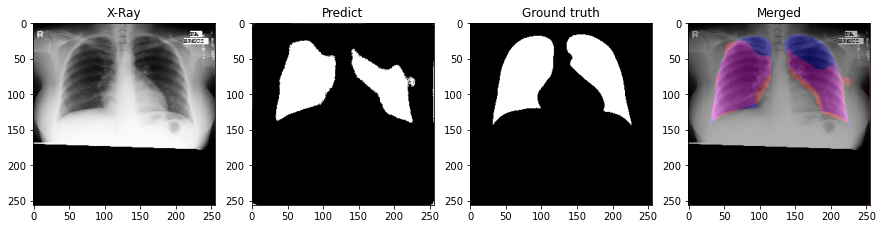

In [184]:
rand = 20
visualiztion(test_image_arr[rand],test_predit_arr[rand],test_mask_arr[rand],0)
print('dice score :',dice_coef_test(test_mask_arr[rand],test_predit_arr[rand],0))

# Dice score and threshold selection

In [115]:
l = []
for item in zip(test_mask_arr,test_predit_arr):
    dice = dice_coef_test(item[0],item[1],0.5)
    l.append(dice)

In [116]:
np.mean(l)

0.6455584687360832

In [117]:
l = []
for item in zip(test_mask_arr,test_predit_arr):
    dice = dice_coef_test(item[0],item[1],0)
    l.append(dice)

In [118]:
np.mean(l)

0.7691427012834262